# CAR SALES using Linear Regression

In [2]:
# imorting libraries 
import pandas as pd 
import numpy as np 
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

## loading the data

In [3]:
# Load the data from a .csv in the same folder
raw_data = pd.read_csv('1.04. Real-life example.csv')

# explore the top 5 rows of the df
raw_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


In [4]:
raw_data.shape

(4345, 9)

In [5]:
raw_data.dtypes

Brand            object
Price           float64
Body             object
Mileage           int64
EngineV         float64
Engine Type      object
Registration     object
Year              int64
Model            object
dtype: object

# Preprocessing 

## exploring descriptive statistics

In [7]:
raw_data.describe(include='all')

# Note that categorical variables don't have some types of numerical descriptives
# and numerical variables don't have some types of categorical descriptives

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,4345,4173.000000,4345,4345.000000,4195.000000,4345,4345,4345.000000,4345
unique,7,NaN,6,NaN,NaN,4,2,NaN,312
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,936,NaN,1649,NaN,NaN,2019,3947,NaN,199
mean,NaN,19418.746935,NaN,161.237284,2.790734,NaN,NaN,2006.550058,NaN
std,NaN,25584.242620,NaN,105.705797,5.066437,NaN,NaN,6.719097,NaN
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000,NaN
25%,NaN,6999.000000,NaN,86.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11500.000000,NaN,155.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000,NaN


In [8]:
# dropping the model column 
data = raw_data.drop(['Model'],axis=1)

In [10]:
raw_data.shape, data.shape

((4345, 9), (4345, 8))

## dealing with missing values

In [11]:
data.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
dtype: int64

In [13]:
# Let's simply drop all missing values
# This is not always recommended, however, when we remove less than 5% of the data, it is okay
data_no_mv = data.dropna(axis=0)

In [14]:
# Let's check the descriptives without the missing values
data_no_mv.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,4025,4025.000000,4025,4025.000000,4025.000000,4025,4025,4025.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,880,NaN,1534,NaN,NaN,1861,3654,NaN
mean,NaN,19552.308065,NaN,163.572174,2.764586,NaN,NaN,2006.379627
std,NaN,25815.734988,NaN,103.394703,4.935941,NaN,NaN,6.695595
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000
25%,NaN,6999.000000,NaN,90.000000,1.800000,NaN,NaN,2003.000000
50%,NaN,11500.000000,NaN,158.000000,2.200000,NaN,NaN,2007.000000
75%,NaN,21900.000000,NaN,230.000000,3.000000,NaN,NaN,2012.000000


## Exploring the probability density function 

/Users/ziiv/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price', ylabel='Density'>

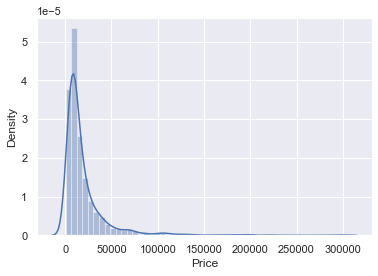

In [15]:
# A great step in the data exploration is to display the probability distribution function (PDF) of a variable
# The PDF will show us how that variable is distributed 
# This makes it very easy to spot anomalies, such as outliers
# The PDF is often the basis on which we decide whether we want to transform a feature
sns.distplot(data_no_mv['Price'])

# dealing with outliers

In [16]:
# Obviously there are some outliers present 

# Without diving too deep into the topic, we can deal with the problem easily by removing 0.5%, or 1% of the problematic samples
# Here, the outliers are situated around the higher prices (right side of the graph)
# Logic should also be applied
# This is a dataset about used cars, therefore one can imagine how $300,000 is an excessive price

# Outliers are a great issue for OLS, thus we must deal with them in some way
# It may be a useful exercise to try training a model without removing the outliers

# Let's declare a variable that will be equal to the 99th percentile of the 'Price' variable
q = data_no_mv['Price'].quantile(0.99)
# Then we can create a new df, with the condition that all prices must be below the 99 percentile of 'Price'
data_1 = data_no_mv[data_no_mv['Price']<q]
# In this way we have essentially removed the top 1% of the data about 'Price'
data_1.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3984,3984.000000,3984,3984.000000,3984.000000,3984,3984,3984.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,880,NaN,1528,NaN,NaN,1853,3613,NaN
mean,NaN,17837.117460,NaN,165.116466,2.743770,NaN,NaN,2006.292922
std,NaN,18976.268315,NaN,102.766126,4.956057,NaN,NaN,6.672745
min,NaN,600.000000,NaN,0.000000,0.600000,NaN,NaN,1969.000000
25%,NaN,6980.000000,NaN,93.000000,1.800000,NaN,NaN,2002.750000
50%,NaN,11400.000000,NaN,160.000000,2.200000,NaN,NaN,2007.000000
75%,NaN,21000.000000,NaN,230.000000,3.000000,NaN,NaN,2011.000000


/Users/ziiv/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price', ylabel='Density'>

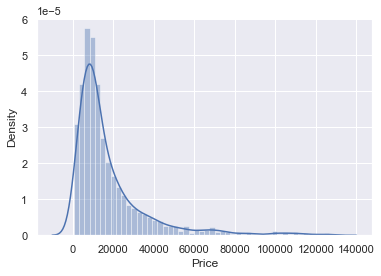

In [17]:
# We can check the PDF once again to ensure that the result is still distributed in the same way overall
# however, there are much fewer outliers
sns.distplot(data_1['Price'])

/Users/ziiv/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Mileage', ylabel='Density'>

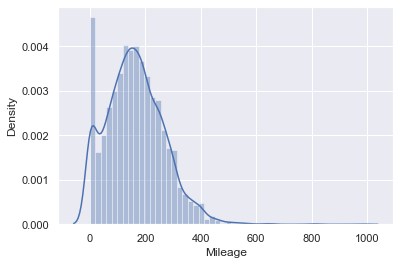

In [18]:
# We can treat the other numerical variables in a similar way
sns.distplot(data_no_mv['Mileage'])

In [19]:
q = data_1['Mileage'].quantile(0.99)
data_2 = data_1[data_1['Mileage']<q]

/Users/ziiv/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Mileage', ylabel='Density'>

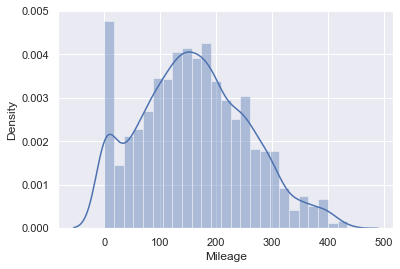

In [20]:
sns.distplot(data_2['Mileage'])

/Users/ziiv/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='EngineV', ylabel='Density'>

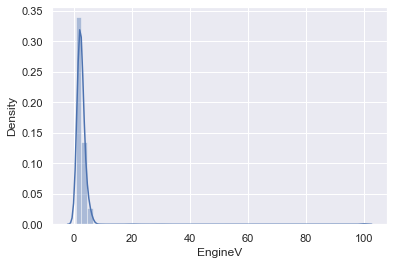

In [21]:
# The situation with engine volume is very strange
# In such cases it makes sense to manually check what may be causing the problem
# In our case the issue comes from the fact that most missing values are indicated with 99.99 or 99
# There are also some incorrect entries like 75
sns.distplot(data_no_mv['EngineV'])

In [22]:
# A simple Google search can indicate the natural domain of this variable
# Car engine volumes are usually (always?) below 6.5l
# This is a prime example of the fact that a domain expert (a person working in the car industry)
# may find it much easier to determine problems with the data than an outsider
data_3 = data_2[data_2['EngineV']<6.5]

/Users/ziiv/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='EngineV', ylabel='Density'>

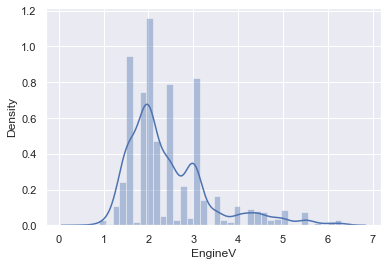

In [23]:
# Following this graph, we realize we can actually treat EngineV as a categorical variable
# Even so, in this  we won't, but that's yet something else we may try 
sns.distplot(data_3['EngineV'])

/Users/ziiv/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Year', ylabel='Density'>

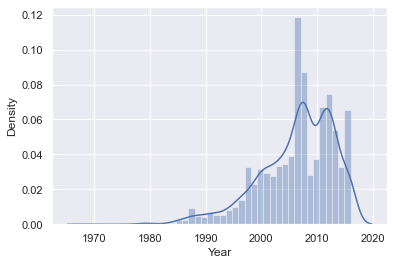

In [24]:
# Finally, the situation with 'Year' is similar to 'Price' and 'Mileage'
# However, the outliers are on the low end
sns.distplot(data_no_mv['Year'])

In [25]:
# I'll simply remove them
q = data_3['Year'].quantile(0.01)
data_4 = data_3[data_3['Year']>q]

/Users/ziiv/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Year', ylabel='Density'>

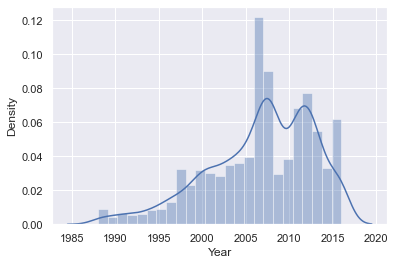

In [26]:
# Here's the new result
sns.distplot(data_4['Year'])

In [27]:
# When we remove observations, the original indexes are preserved
# If we remove observations with indexes 2 and 3, the indexes will go as: 0,1,4,5,6
# That's very problematic as we tend to forget about it (later you will see an example of such a problem)

# Finally, once we reset the index, a new column will be created containing the old index (just in case)
# We won't be needing it, thus 'drop=True' to completely forget about it
data_cleaned = data_4.reset_index(drop=True)

In [28]:
# Let's see what's left
data_cleaned.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year
count,3867,3867.000000,3867,3867.000000,3867.000000,3867,3867,3867.000000
unique,7,NaN,6,NaN,NaN,4,2,NaN
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN
freq,848,NaN,1467,NaN,NaN,1807,3505,NaN
mean,NaN,18194.455679,NaN,160.542539,2.450440,NaN,NaN,2006.709853
std,NaN,19085.855165,NaN,95.633291,0.949366,NaN,NaN,6.103870
min,NaN,800.000000,NaN,0.000000,0.600000,NaN,NaN,1988.000000
25%,NaN,7200.000000,NaN,91.000000,1.800000,NaN,NaN,2003.000000
50%,NaN,11700.000000,NaN,157.000000,2.200000,NaN,NaN,2008.000000
75%,NaN,21700.000000,NaN,225.000000,3.000000,NaN,NaN,2012.000000


# checking the ols assumptions

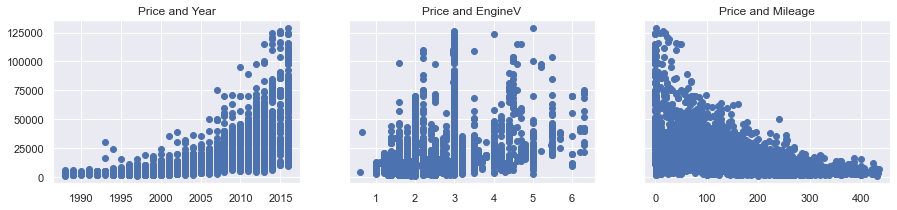

In [29]:
# But since Price is the 'y' axis of all the plots, it made sense to plot them side-by-side (so we can compare them)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3)) #sharey -> share 'Price' as y
ax1.scatter(data_cleaned['Year'],data_cleaned['Price'])
ax1.set_title('Price and Year')
ax2.scatter(data_cleaned['EngineV'],data_cleaned['Price'])
ax2.set_title('Price and EngineV')
ax3.scatter(data_cleaned['Mileage'],data_cleaned['Price'])
ax3.set_title('Price and Mileage')


plt.show()

/Users/ziiv/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Price', ylabel='Density'>

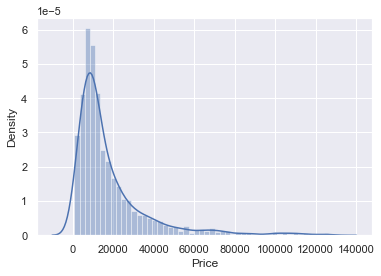

In [30]:
# From the subplots and the PDF of price, we can easily determine that 'Price' is exponentially distributed
# A good transformation in that case is a log transformation
sns.distplot(data_cleaned['Price'])

## relaxing the assumptions

In [31]:
# Let's transform 'Price' with a log transformation
log_price = np.log(data_cleaned['Price'])

# Then we add it to our data frame
data_cleaned['log_price'] = log_price
data_cleaned

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,log_price
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,8.342840
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,8.974618
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,9.495519
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,10.043249
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,9.814656
...,...,...,...,...,...,...,...,...,...
3862,Volkswagen,11500.0,van,163,2.5,Diesel,yes,2008,9.350102
3863,Toyota,17900.0,sedan,35,1.6,Petrol,yes,2014,9.792556
3864,Mercedes-Benz,125000.0,sedan,9,3.0,Diesel,yes,2014,11.736069
3865,BMW,6500.0,sedan,1,3.5,Petrol,yes,1999,8.779557


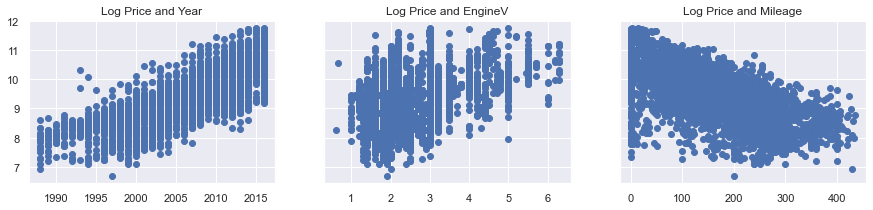

In [32]:
# Let's check the three scatters once again
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize =(15,3))
ax1.scatter(data_cleaned['Year'],data_cleaned['log_price'])
ax1.set_title('Log Price and Year')
ax2.scatter(data_cleaned['EngineV'],data_cleaned['log_price'])
ax2.set_title('Log Price and EngineV')
ax3.scatter(data_cleaned['Mileage'],data_cleaned['log_price'])
ax3.set_title('Log Price and Mileage')


plt.show()

# The relationships show a clear linear relationship
# This is some good linear regression material

# Alternatively we could have transformed each of the independent variables

In [33]:
# Since we will be using the log price variable, we can drop the old 'Price' one
data_cleaned = data_cleaned.drop(['Price'],axis=1)

## multicollinearity

In [34]:
data_cleaned.columns.values

array(['Brand', 'Body', 'Mileage', 'EngineV', 'Engine Type',
       'Registration', 'Year', 'log_price'], dtype=object)

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# To make this as easy as possible to use, we declare a variable where we put
# all features where we want to check for multicollinearity
# since our categorical data is not yet preprocessed, we will only take the numerical ones
variables = data_cleaned[['Mileage','Year','EngineV']]

# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = variables.columns

In [36]:
vif

,VIF,Features
0,3.791584,Mileage
1,10.354854,Year
2,7.662068,EngineV


In [37]:
# Since Year has the highest VIF, I will remove it from the model
# This will drive the VIF of other variables down!!! 
# So even if EngineV seems with a high VIF, too, once 'Year' is gone that will no longer be the case
data_no_multicollinearity = data_cleaned.drop(['Year'],axis=1)

In [38]:
variables = data_cleaned[['Mileage','EngineV']]

# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = variables.columns
vif

,VIF,Features
0,2.805214,Mileage
1,2.805214,EngineV


# creating dummy variables

In [39]:
# To include the categorical data in the regression, let's create dummies
# There is a very convenient method called: 'get_dummies' which does that seemlessly
# It is extremely important that we drop one of the dummies, alternatively we will introduce multicollinearity
data_with_dummies = pd.get_dummies(data_no_multicollinearity, drop_first=True)

In [40]:
data_with_dummies.head()

,Mileage,EngineV,log_price,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,277,2.0,8.342840,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,427,2.9,8.974618,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,358,5.0,9.495519,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,240,4.2,10.043249,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,120,2.0,9.814656,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


In [41]:
# To make our data frame more organized, we prefer to place the dependent variable in the beginning of the df
# Since each problem is different, that must be done manually
# We can display all possible features and then choose the desired order
data_with_dummies.columns.values

array(['Mileage', 'EngineV', 'log_price', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes'],
      dtype=object)

In [42]:
# To make the code a bit more parametrized, let's declare a new variable that will contain the preferred order
# If you want a different order, just specify it here
# Conventionally, the most intuitive order is: dependent variable, indepedendent numerical variables, dummies
cols = ['log_price', 'Mileage', 'EngineV', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol', 'Registration_yes']

In [43]:
# To implement the reordering, we will create a new df, which is equal to the old one but with the new order of features
data_preprocessed = data_with_dummies[cols]
data_preprocessed.head()

,log_price,Mileage,EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,8.342840,277,2.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,8.974618,427,2.9,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,9.495519,358,5.0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,10.043249,240,4.2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,9.814656,120,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


Calculate the variance inflation factors for all variables contained in data_preprocessed.

In [44]:
# Let's simply use the data_preprocessed and the VIF code from above
variables = data_preprocessed
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,41.981260,log_price
1,4.460434,Mileage
2,13.445639,EngineV
3,2.603990,Brand_BMW
4,3.084356,Brand_Mercedes-Benz
5,1.830297,Brand_Mitsubishi
6,2.281498,Brand_Renault
7,2.406546,Brand_Toyota
8,3.312814,Brand_Volkswagen
9,1.583516,Body_hatch


In [45]:
# Let's simply drop log_price from data_preprocessed
variables = data_preprocessed.drop(['log_price'],axis=1)
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,4.459662,Mileage
1,7.841729,EngineV
2,2.294007,Brand_BMW
3,2.868649,Brand_Mercedes-Benz
4,1.641712,Brand_Mitsubishi
5,2.086774,Brand_Renault
6,2.162166,Brand_Toyota
7,2.844515,Brand_Volkswagen
8,1.464260,Body_hatch
9,1.534059,Body_other


The ones that are particularly high are 'EngineV' and 'Registration_yes'.
We already discussed 'EngineV' in the lecture.
In the case of registration, the main issue is that most values are 'yes' so all types of problems come from there. One way this imbalance manifests is in multicollinearity. Remember that all independent variables are pretty good at determining 'log_price'? Well, if 'registration' is always 'yes', then if we predict 'log_price' we are predicting registration, too (it is going to be 'yes'). That is why, whenever a single category is so predominant, we may just drop the variable.


In [46]:
data_preprocessed = data_preprocessed.drop(['Registration_yes'],axis=1)

# Linear Regression model

In [47]:
# The target(s) (dependent variable) is 'log price'
targets = data_preprocessed['log_price']

# The inputs are everything BUT the dependent variable, so we can simply drop it
inputs = data_preprocessed.drop(['log_price'],axis=1)

## scaling the data

In [48]:
# Import the scaling module
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()
# Fit the inputs (calculate the mean and standard deviation feature-wise)
scaler.fit(inputs)

StandardScaler()

In [49]:
# Scale the features and store them in a new variable (the actual scaling procedure)
inputs_scaled = scaler.transform(inputs)

## train and split

In [50]:
# Import the module for the split
from sklearn.model_selection import train_test_split

# Split the variables with an 80-20 split and some random state
# To have the same split as mine, use random_state = 365
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

## regression 

In [51]:
# Create a linear regression object
reg = LinearRegression()
# Fit the regression with the scaled TRAIN inputs and targets
reg.fit(x_train,y_train)

# Let's check the outputs of the regression
y_hat = reg.predict(x_train)

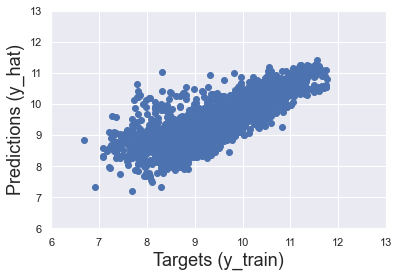

In [52]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(y_train, y_hat)
# Let's also name the axes
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
# Sometimes the plot will have different scales of the x-axis and the y-axis
# This is an issue as we won't be able to interpret the '45-degree line'
# We want the x-axis and the y-axis to be the same
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

/Users/ziiv/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Residuals PDF')

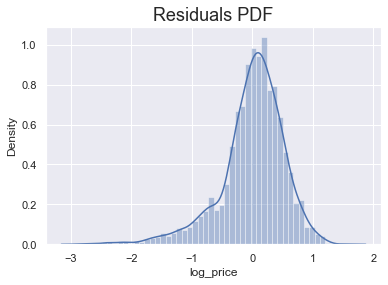

In [53]:
# Another useful check of our model is a residual plot
# We can plot the PDF of the residuals and check for anomalies
sns.distplot(y_train - y_hat)

# Include a title
plt.title("Residuals PDF", size=18)

# In the best case scenario this plot should be normally distributed
# In our case we notice that there are many negative residuals (far away from the mean)
# Given the definition of the residuals (y_train - y_hat), negative values imply
# that y_hat (predictions) are much higher than y_train (the targets)
# This is food for thought to improve our model

In [54]:
# Find the R-squared of the model
reg.score(x_train,y_train)

0.6327932829432332

## finding weights and bias

In [55]:
# Obtain the bias (intercept) of the regression
reg.intercept_

9.416736021792213

In [56]:
# Obtain the weights (coefficients) of the regression
reg.coef_

array([-0.51533512,  0.21967031,  0.02193221,  0.05613578, -0.11389539,
       -0.13005783, -0.02169288, -0.04189507, -0.16947147, -0.10072502,
       -0.22330322, -0.17441764, -0.13944436, -0.07458352, -0.03385346,
       -0.09429784])

In [57]:
# Create a regression summary where we can compare them with one-another
reg_summary = pd.DataFrame(inputs.columns.values, columns=['Features'])
reg_summary['Weights'] = reg.coef_
reg_summary

,Features,Weights
0,Mileage,-0.515335
1,EngineV,0.219670
2,Brand_BMW,0.021932
3,Brand_Mercedes-Benz,0.056136
4,Brand_Mitsubishi,-0.113895
5,Brand_Renault,-0.130058
6,Brand_Toyota,-0.021693
7,Brand_Volkswagen,-0.041895
8,Body_hatch,-0.169471
9,Body_other,-0.100725


In [58]:
# Check the different categories in the 'Brand' variable
data_cleaned['Brand'].unique()

# In this way we can see which 'Brand' is actually the benchmark

array(['BMW', 'Mercedes-Benz', 'Audi', 'Toyota', 'Renault', 'Volkswagen',
       'Mitsubishi'], dtype=object)

# Testing

In [59]:
# Once we have trained and fine-tuned our model, we can proceed to testing it
# Testing is done on a dataset that the algorithm has never seen
# Luckily we have prepared such a dataset
# Our test inputs are 'x_test', while the outputs: 'y_test' 
# We SHOULD NOT TRAIN THE MODEL ON THEM, we just feed them and find the predictions
# If the predictions are far off, we will know that our model overfitted
y_hat_test = reg.predict(x_test)

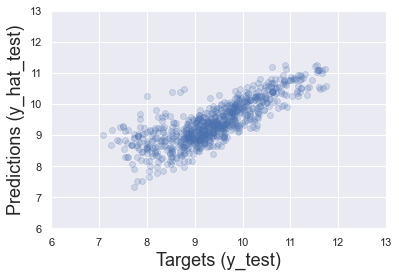

In [60]:
# Create a scatter plot with the test targets and the test predictions
# You can include the argument 'alpha' which will introduce opacity to the graph
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [61]:
# Finally, let's manually check these predictions
# To obtain the actual prices, we take the exponential of the log_price
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

,Prediction
0,8290.962337
1,10030.951704
2,7728.513416
3,7106.617356
4,8946.423009


In [62]:
# We can also include the test targets in that data frame (so we can manually compare them)
df_pf['Target'] = np.exp(y_test)
df_pf

# Note that we have a lot of missing values
# There is no reason to have ANY missing values, though
# This suggests that something is wrong with the data frame / indexing

,Prediction,Target
0,8290.962337,NaN
1,10030.951704,7900.0
2,7728.513416,NaN
3,7106.617356,NaN
4,8946.423009,NaN
...,...,...
769,26268.588614,6950.0
770,10780.764943,NaN
771,13713.032196,NaN
772,33687.384652,NaN


In [63]:
# After displaying y_test, we find what the issue is
# The old indexes are preserved (recall earlier in that code we made a note on that)
# The code was: data_cleaned = data_4.reset_index(drop=True)

# Therefore, to get a proper result, we must reset the index and drop the old indexing
y_test = y_test.reset_index(drop=True)

# Check the result
y_test.head()

0    7.740664
1    7.937375
2    7.824046
3    8.764053
4    9.121509
Name: log_price, dtype: float64

In [64]:
# Let's overwrite the 'Target' column with the appropriate values
# Again, we need the exponential of the test log price
df_pf['Target'] = np.exp(y_test)
df_pf

,Prediction,Target
0,8290.962337,2300.0
1,10030.951704,2800.0
2,7728.513416,2500.0
3,7106.617356,6400.0
4,8946.423009,9150.0
...,...,...
769,26268.588614,29500.0
770,10780.764943,9600.0
771,13713.032196,18300.0
772,33687.384652,68500.0


In [65]:
# Additionally, we can calculate the difference between the targets and the predictions
# Note that this is actually the residual (we already plotted the residuals)
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

# Since OLS is basically an algorithm which minimizes the total sum of squared errors (residuals),
# this comparison makes a lot of sense

# Finally, it makes sense to see how far off we are from the result percentage-wise
# Here, we take the absolute difference in %, so we can easily order the data frame
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf

,Prediction,Target,Residual,Difference%
0,8290.962337,2300.0,-5990.962337,260.476623
1,10030.951704,2800.0,-7230.951704,258.248275
2,7728.513416,2500.0,-5228.513416,209.140537
3,7106.617356,6400.0,-706.617356,11.040896
4,8946.423009,9150.0,203.576991,2.224885
...,...,...,...,...
769,26268.588614,29500.0,3231.411386,10.953937
770,10780.764943,9600.0,-1180.764943,12.299635
771,13713.032196,18300.0,4586.967804,25.065398
772,33687.384652,68500.0,34812.615348,50.821336


In [66]:
# Exploring the descriptives here gives us additional insights
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,774.000000,774.000000,774.000000,774.000000
mean,15560.322365,18165.817106,2605.494741,48.389560
std,12785.178475,19967.858908,11277.429072,79.150473
min,1534.536742,1200.000000,-31976.552299,0.099578
25%,7364.900478,6900.000000,-2340.797923,13.241638
50%,10989.862225,11600.000000,638.119126,27.328555
75%,19119.870780,20500.000000,3916.897156,48.155373
max,76166.153837,126000.000000,87273.596622,854.045645


In [67]:
# Sometimes it is useful to check these outputs manually
# To see all rows, we use the relevant pandas syntax
pd.options.display.max_rows = 999
# Moreover, to make the dataset clear, we can display the result with only 2 digits after the dot 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# Finally, we sort by difference in % and manually check the model
df_pf.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
258,11888.15,11900.00,11.85,0.10
23,12913.98,12900.00,-13.98,0.11
165,9389.32,9400.00,10.68,0.11
508,14953.31,15000.00,46.69,0.31
261,48364.18,48535.50,171.32,0.35
270,7728.32,7700.00,-28.32,0.37
438,17094.06,16999.00,-95.06,0.56
484,11667.91,11600.00,-67.91,0.59
446,8958.69,8900.00,-58.69,0.66
31,12748.39,12650.00,-98.39,0.78
